<a href="https://colab.research.google.com/github/mariano10792/BDA_py_demos/blob/master/demo3_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Bayesian Data Analysis, 3rd ed
##  Chapter 3, demo 6

Illustrate posterior inference for Bioassay data (BDA3 p. 74-).

#### Instructions for exercise (3.11 in BDA3)
- Check that the range and spacing of A and B are sensible for the 
  alternative prior
- Compute the log-posterior in a grid
- Scale the log-posterior by subtracting its maximum value before
  exponentiating (think why this is useful)
- Exponentiate
- Normalize the posterior
- Use 2D grid sampling 
- In addition to the plots, report p(beta>0|x,y)

In [ ]:
import numpy as np
from scipy.special import expit  # aka logistic
from scipy import optimize, stats

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
import os, sys
# add utilities directory to path
# util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
# if util_path not in sys.path and os.path.exists(util_path):
#     sys.path.insert(0, util_path)

# import from utilities
import plot_tools

In [ ]:
# edit default plot settings
plt.rc('font', size=12)
# apply custom background plotting style
plt.style.use(plot_tools.custom_styles['gray_background'])

In [ ]:
# seed a random state
rng = np.random.RandomState(0)

In [ ]:
# data
x = np.array([-0.86, -0.30, -0.05, 0.73])
n = np.array([5, 5, 5, 5])
y = np.array([0, 1, 3, 5])

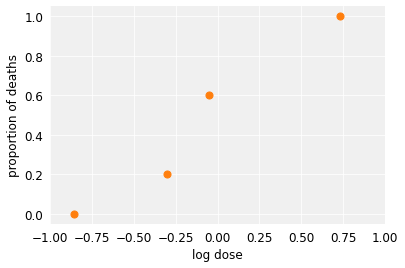

In [ ]:
# plot the data
plt.scatter(x, y/n, 50, color='C1')
plt.xlim((-1, 1))
plt.xlabel('log dose')
plt.ylabel('proportion of deaths');

# **HASTA DIAPOSITIVA 1**

In [ ]:
# compute the posterior density in grid
#  - usually should be computed in logarithms!
#  - with alternative prior, check that range and spacing of A and B
#    are sensible
A = np.linspace(-4, 8, 100)
B = np.linspace(-10, 40, 100)
ilogit_abx = 1 / (np.exp(-(A[:,None] + B[:,None,None] * x)) + 1)

p = np.prod(ilogit_abx**y * (1 - ilogit_abx)**(n - y), axis=2) #likelihood

In [ ]:
# sample from the grid
nsamp = 1000
samp_indices = np.unravel_index( #esta magia agarra indices mas probables de p y con esos computa los A y B mas probables
    rng.choice(p.size, size=nsamp, p=p.ravel()/np.sum(p)),
    p.shape
)

samp_A = A[samp_indices[1]]
samp_B = B[samp_indices[0]]
# add random jitter, see BDA3 p. 76
# makes the distribution look "continuous"
samp_A += (rng.rand(nsamp) - 0.5) * (A[1]-A[0])
samp_B += (rng.rand(nsamp) - 0.5) * (B[1]-B[0])

# samples of LD50 conditional beta > 0
bpi = samp_B > 0
samp_ld50 = -samp_A[bpi]/samp_B[bpi]
# print(samp_ld50)

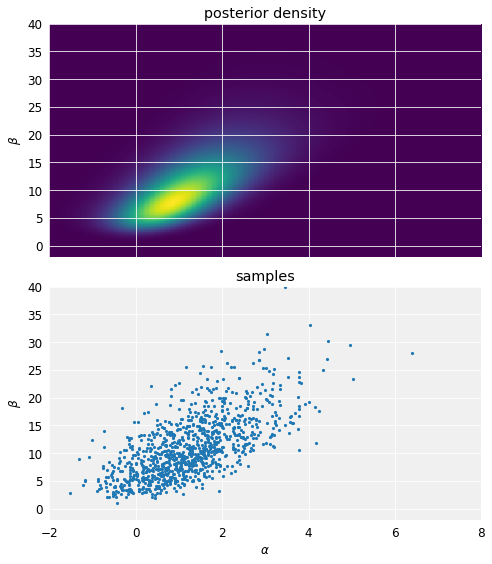

In [ ]:
#create figure
fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# plot the posterior density
ax = axes[0]
ax.imshow(p, origin='lower', aspect='auto', extent=(A[0], A[-1], B[0], B[-1]))
ax.set_xlim([-2,8])
ax.set_ylim([-2,40])
ax.set_ylabel(r'$\beta$')
ax.grid('off')
ax.set_title('posterior density')

# plot the samples
ax = axes[1]
ax.scatter(samp_A, samp_B, 10, linewidth=0)
ax.set_xlim([-2,8])
ax.set_ylim([-2,40])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_title('samples')

fig.tight_layout()

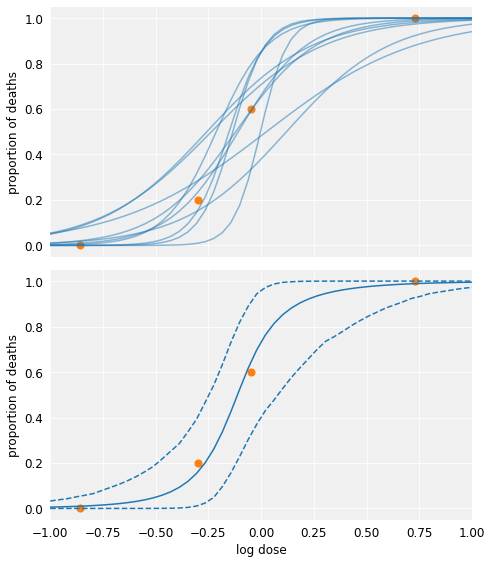

In [ ]:
# plot samples with the data
xt = np.linspace(-1, 1)
fs = expit(samp_A[:, None] + samp_B[:, None]*xt)

# ceate figure
fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# plot 10 first samples
ax = axes[0]
ax.plot(xt, fs[:10].T, color='C0', alpha=0.5)
ax.scatter(x, y/n, 50, color='C1')
ax.set_xlim((-1, 1))
ax.set_ylabel('proportion of deaths')

# plot mean and [5% 95%] interval
ax = axes[1]
ax.plot(xt, np.mean(fs, axis=0).T, color='C0')
ax.plot(
    xt,
    np.percentile(fs, [5, 95], axis=0).T,
    color='C0',
    linestyle='--'
)
ax.scatter(x, y/n, 50, color='C1')
ax.set_xlim((-1, 1))
ax.set_xlabel('log dose')
ax.set_ylabel('proportion of deaths')

fig.tight_layout()

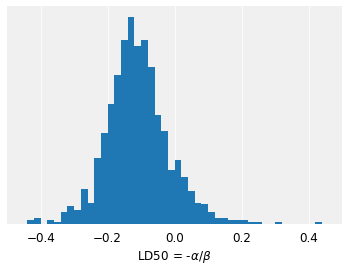

In [ ]:
# plot the histogram of LD50
plt.hist(samp_ld50, np.arange(-0.5, 0.51, 0.02))
plt.xlim([-0.5, 0.5])
plt.xlabel(r'LD50 = -$\alpha/\beta$')
plt.yticks(());

# **HASTA DIAPOSITIVA 2**


# **APROXIMACION NORMAL**

In [ ]:
# samples of LD50 without the constrains on B.
samp_ld50 = - samp_A / samp_B
# griding, needed for the next example
ngrid = 100

Find the mode by minimising negative log posterior. Compute gradients and Hessian analytically, and use Newton's method for optimisation. You may use optimisation routines below for checking your results. See help for scipy.optimize.minimize.

In [ ]:
# define the optimised function
def bioassayfun(w):
    a = w[0]
    b = w[1]
    et = np.exp(a + b * x)
    z = et / (1 + et)
    e = - np.sum(y * np.log(z) + (n - y) * np.log(1 - z))
    return e
# initial guess
w0 = np.array([0.0, 0.0])
# optimise
optim_res = optimize.minimize(bioassayfun, w0)

# extract desired results
w = optim_res['x'] #The solution of the optimization.
S = optim_res['hess_inv']
#Inverse of the objective function’s Hessian; may be an approximation. 
#Not available for all solvers. The type of this attribute may be either np.ndarray or scipy.sparse.linalg.LinearOperator.
print(w)
print(S)

[0.84658413 7.74882399]
[[ 0.97178147  3.46331377]
 [ 3.46331377 23.62479565]]


In [ ]:
# compute the normal approximation density in grid
# this is just for the illustration

# Construct a grid array of shape (ngrid, ngrid, 2) from A and B. Although
# Numpy's concatenation functions do not support broadcasting, a clever trick
# can be applied to overcome this without unnecessary memory copies
# (see Numpy's documentation for strides for more information):
A_broadcasted = np.lib.stride_tricks.as_strided(
    A, shape=(ngrid,ngrid), strides=(0, A.strides[0]))
# print(A.shape)
# print(A)
# print(A_broadcasted.shape)
# print(A_broadcasted)
B_broadcasted = np.lib.stride_tricks.as_strided(
    B, shape=(ngrid,ngrid), strides=(B.strides[0], 0))
grid = np.dstack((A_broadcasted, B_broadcasted))
print(grid.shape)
p_norm = stats.multivariate_normal.pdf(x=grid, mean=w, cov=S)

# draw samples from the distribution
samp_norm = stats.multivariate_normal.rvs(mean=w, cov=S, size=1000)

(100, 100, 2)


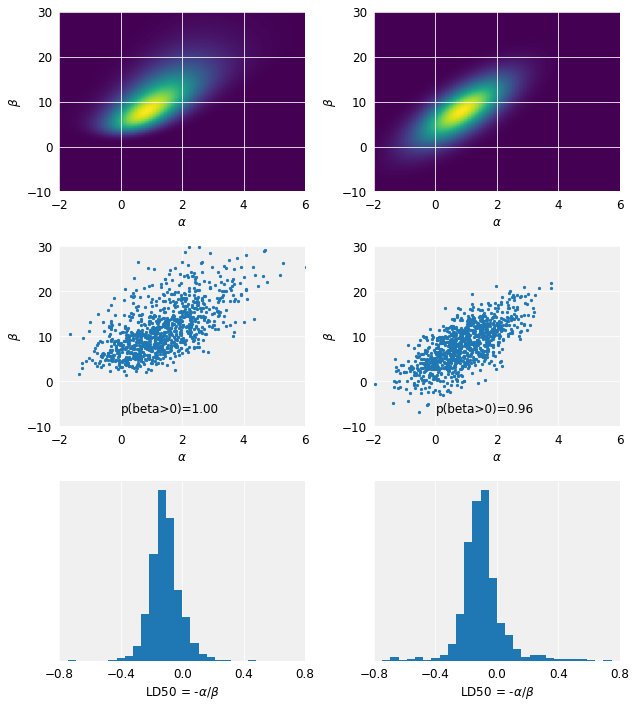

In [ ]:
# create figure
fig, axes = plt.subplots(3, 2, figsize=(9, 10))

# plot the posterior density
ax = axes[0, 0]
ax.imshow(
    p,
    origin='lower',
    aspect='auto',
    extent=(A[0], A[-1], B[0], B[-1])
)
ax.set_xlim([-2, 6])
ax.set_ylim([-10, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.grid('off')

# plot the samples
ax = axes[1, 0]
ax.scatter(samp_A, samp_B, 5)
ax.set_xlim([-2, 6])
ax.set_ylim([-10, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.text(0, -7, 'p(beta>0)={:.2f}'.format(np.mean(samp_B>0)))

# plot the histogram of LD50
ax = axes[2, 0]
ax.hist(samp_ld50, np.linspace(-0.8, 0.8, 31))
ax.set_xlim([-0.8, 0.8])
ax.set_xlabel(r'LD50 = -$\alpha/\beta$')
ax.set_yticks(())
ax.set_xticks(np.linspace(-0.8, 0.8, 5))

# plot the posterior density for normal approx.
ax = axes[0, 1]
ax.imshow(
    p_norm,
    origin='lower',
    aspect='auto',
    extent=(A[0], A[-1], B[0], B[-1])
)
ax.set_xlim([-2, 6])
ax.set_ylim([-10, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.grid('off')

# plot the samples from the normal approx.
ax = axes[1, 1]
ax.scatter(samp_norm[:,0], samp_norm[:,1], 5)
ax.set_xlim([-2, 6])
ax.set_ylim([-10, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')

# Normal approximation does not take into account that the posterior
# is not symmetric and that there is very low density for negative
# beta values. Based on the samples from the normal approximation
# it is estimated that there is about 4% probability that beta is negative!
ax.text(0, -7, 'p(beta>0)={:.2f}'.format(np.mean(samp_norm[:,1]>0)))

# Plot the histogram of LD50
ax = axes[2, 1]
# Since we have strong prior belief that beta should not be negative we can
# improve our normal approximation by conditioning on beta>0.
bpi = samp_norm[:,1] > 0
samp_ld50_norm = - samp_norm[bpi,0] / samp_norm[bpi,1]
ax.hist(samp_ld50_norm, np.linspace(-0.8, 0.8, 31))
ax.set_xlim([-0.8, 0.8])
ax.set_xlabel(r'LD50 = -$\alpha/\beta$')
ax.set_yticks(())
ax.set_xticks(np.linspace(-0.8, 0.8, 5))

fig.tight_layout()
